<a href="https://colab.research.google.com/github/HJoonKwon/ml_fundamentals/blob/main/BinaryLogisticRegressionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Binary Logistic Regression 
- Supervised learning algorithm 
- Discriminative classifier
- Use an activation function called logistic function or sigmod function 
- Minimize binary cross engropy loss 
  - There is no closed-form solution
  - So, we should use gradient descent to find an optimal solution.

## How does it work? 
- The network will predict the probability of the output being positive. 
- The output of the network looks like below:
$$ z = (\sum_{i=1}^n w_i x_i) + b$$
$$ ŷ = sigmoid(z) = \frac{1}{1+e^{-z}}$$
- The output ```y```, the probability of being positive, always falls into ```[0, 1]```
- The update equation based on gradient descent is:
$$ \theta := \theta - η∇L(ŷ, y)$$
- ```L``` is the binary cross-entropy loss which can be defined as:
$$ L_{CE}(ŷ,y) = -\frac{1}{m} \sum_{i=1}^m [ylog(ŷ) + (1-y)log(1-ŷ)]$$
- The partial derivatives of ```L``` with respect to ```w``` and ```b``` are:
$$ \frac{∂L_{CE}(ŷ, y)}{∂w} = \frac{1}{m}(ŷ-y)x_i^T$$
$$ \frac{∂L_{CE}(ŷ, y)}{∂b} = \frac{1}{m}(ŷ-y)1^T$$ 


## Stable sigmoid trick 
- The original sigmoid function becomes numerically unstable when ```z``` is a very small negative number. (Overflow)
- This problem can be solved using the trick below:
  - if ```z >= 0```
$$ sigmod(z) = \frac{1}{1+e^{-z}}$$ 
  - if ```z < 0```
$$ sigmoid(z) = \frac{e^z}{1+e^z}$$
- Both of the equations are mathematically the same, so it will not change the value of the output.

In [1]:
import numpy as np 
import math 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

## 1) Prepare for dataset 
- We are going to use Breast [Breast cancer wisconsin (diagnostic) dataset text](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset)
- Load, normalize, and split the dataset 

In [2]:
def normalize(data: np.ndarray):
  data = (data-np.mean(data, axis=0))/np.std(data, axis=0)
  return data 

In [3]:
dataset = load_breast_cancer() 
X = dataset['data']
y = dataset['target']
target_names = dataset['target_names']
feature_names = dataset['feature_names']
print(X.shape)
print(y.shape)
print(X[0])
print(y[0])
print(f'feature_names: {feature_names}')
print(f'target_names: {target_names}')

(569, 30)
(569,)
[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
0
feature_names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
target_names: ['malignant' 'benign']


In [8]:
X = normalize(X)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print(train_X.shape)
print(test_X.shape)
print(test_y.shape)
print(train_X[0])

(455, 30)
(114, 30)
(114,)
[-1.44798723 -0.45602336 -1.36665103 -1.15012411  0.72871411  0.70042803
  2.81483311 -0.13333286  1.09302444  2.5038276  -0.28069568 -0.04146398
 -0.48565435 -0.49871449  0.83604093  3.38589232  9.01560288  3.47515764
  2.594434    2.1802771  -1.2340441  -0.4929645  -1.24389273 -0.97719402
  0.69398379  1.15926893  4.7006688   0.91959172  2.14719008  1.85943247]


## 2) Implement stable Sigmod 

In [21]:
def sigmoid(z):
  if z >= 0:
    y = 1 / (1 + math.exp(-z))
  else:
    y = math.exp(z) / (1 + math.exp(z))
  return y 

## 3) Define Cross-Entroy Loss and Gradients 

In [31]:
EPS = 1e-9

def cross_entropy(y_gt: np.ndarray, y_pred: np.ndarray):
  num_samples = y_gt.shape[0]
  loss = y_gt * np.log(y_pred + EPS) + (1 - y_gt) * np.log(1 - y_pred + EPS)
  loss = -np.mean(loss)
  return loss 

def gradients_of_cross_entropy(x: np.ndarray, y_gt: np.ndarray, y_pred: np.ndarray):
  diff = y_pred - y_gt
  diff = diff[:, None]
  grad_weights = np.matmul(x.transpose(), diff) / x.shape[0] # (nxm) * (mx1) = (nx1) 
  grad_bias = np.mean(diff)
  return grad_weights, grad_bias 


## 4) Implement Logistic Regression 

In [36]:
from typing import Callable

class BinaryLogisticRegressor():
  
  def __init__(self, learning_rate: float = 0.1):
    self.lr = learning_rate 
    self.test_X = None 
    self.test_Y = None 
    self.weights = None 
    self.bias = None 
    self.train_loss = [] 
    self.test_loss = [] 

  def fit(self, X, y, epochs):
    self._initialize_model(X)
    for epoch in range(epochs):
      z = np.matmul(X, self.weights) + self.bias # (mxn) * (nx1) = (mx1)
      pred = self._sigmoid(z)
      assert y.shape == pred.shape, print(y.shape, pred.shape)
      loss = cross_entropy(y, pred)
      grad_w, grad_b = self._calculate_gradients(X, y, pred)
      self._update_model(grad_w, grad_b)
      self.train_loss.append(loss)

      # test set 
      z = np.matmul(self.test_X, self.weights) + self.bias 
      pred = self._sigmoid(z)
      assert self.test_y.shape == pred.shape 
      loss = cross_entropy(self.test_y, pred)
      self.test_loss.append(loss)

      if epoch % 5 == 0:
        print(f"epoch{epoch}: train_loss: {self.train_loss[-1]}")
        print(f"epoch{epoch}: test_loss: {self.test_loss[-1]}")

    
  def predict(self, X):
    z = np.matmul(X, self.weights) + self.bias
    pred = self._sigmoid(z)
    pred = np.array([1 if p > 0.5 else 0 for p in pred])
    return pred 
  
  def evaluate(self, pred, y):
    assert pred.shape == y.shape
    acc = sum(pred==y)/len(y)
    return acc 

  def set_test_data(self, test_X, test_y):
    self.test_X = test_X 
    self.test_y = test_y 
  
  def _calculate_gradients(self, X, y, pred):
    return gradients_of_cross_entropy(X, y, pred)
  
  def _update_model(self, grad_w, grad_b):
    self.weights -= self.lr * grad_w
    self.bias -= self.lr * grad_b 
  
  def _initialize_model(self, X):
    self.weights = np.zeros((X.shape[1], 1))
    self.bias = 0 
  
  def _sigmoid(self, z: np.ndarray):
    return np.array([sigmoid(ele) for ele in z])


In [40]:
epochs = 50 
binary_logistic_regressor = BinaryLogisticRegressor()
binary_logistic_regressor.set_test_data(test_X, test_y)
binary_logistic_regressor.fit(train_X, train_y, epochs)
pred = binary_logistic_regressor.predict(test_X)
acc = binary_logistic_regressor.evaluate(pred, test_y)
print(f"test acc is {acc}")


epoch0: train_loss: 0.6931471785599452
epoch0: test_loss: 0.5174830195071337
epoch5: train_loss: 0.3215512990373032
epoch5: test_loss: 0.28288541825697944
epoch10: train_loss: 0.24578979756220853
epoch10: test_loss: 0.21823121994599315
epoch15: train_loss: 0.20915066080985506
epoch15: test_loss: 0.18520510932581902
epoch20: train_loss: 0.18663397651033933
epoch20: test_loss: 0.16445860448396513
epoch25: train_loss: 0.1711020300952463
epoch25: test_loss: 0.14995551774562701
epoch30: train_loss: 0.15960967374191515
epoch30: test_loss: 0.13912983436308618
epoch35: train_loss: 0.15068757855493498
epoch35: test_loss: 0.1306822636866457
epoch40: train_loss: 0.14351272318582992
epoch40: test_loss: 0.12387515917407464
epoch45: train_loss: 0.13758573018232328
epoch45: test_loss: 0.11825448654064126
test acc is 0.9824561403508771


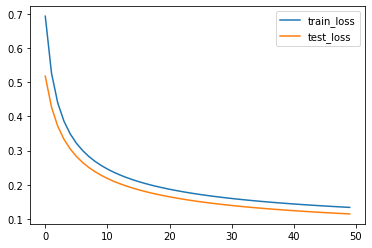

In [41]:
import matplotlib.pyplot as plt

plt.figure() 
plt.plot(range(epochs), binary_logistic_regressor.train_loss, label='train_loss')
plt.plot(range(epochs), binary_logistic_regressor.test_loss, label='test_loss')
plt.legend()

## References 
- https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/
- https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
- https://web.stanford.edu/~jurafsky/slp3/5.pdf